# Benchamrking


In [1]:
import sys
sys.path.append("../")
# import syn data generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from synthetic_data_generation.syn_gyn_module import (
    Metric,
    UnitCov,
    IntCov,
    SyntheticDataModule,
)

from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causallib.estimation import IPW, Standardization, StratifiedStandardization
from causallib.estimation import AIPW, PropensityFeatureStandardization, WeightedStandardization
from causallib.evaluation import evaluate
from algorithms.snn_biclustering import SNNBiclustering, SNN
from algorithms.fill_tensor_ALS import ALS


In [17]:
def generate_syn_data(T = 50, seed = None):

    np.random.seed(seed)

    # Define some metrics
    metric1 = Metric("sales", metric_range=[0, 500])
    metrics = [metric1]

    # Interventions: Daily promotional emails frequency: none, daily, weekly
    num_interventions = 3

    # unit covariates: location and size
    loc = UnitCov("location", categories=["East coast", "West coast", "Midwest"])
    age = UnitCov("age", categories=["<25", "25-35", "35-50", ">50"])
    unit_cov = [loc, age]

    # intervention covariates:
    treatment = IntCov(
        "emails",
        discrete=True,
        categories=["None", "Daily", "Weekly"],
        divisions=3,
        assignment=[0, 1, 2], # Note that the assignments here makes the 
                              # association between no emails and intervention 0, 
                              # daily emails with  intervention 1, etc ..
    )
    int_cov = [treatment]

    # num of units (customer groups)
    N = 200
    # initalize and generate
    data = SyntheticDataModule(
        N,
        T,
        num_interventions,
        metrics,
        unit_cov,
        int_cov,
        freq="1D"
    )

    # generate initial factors
    data.generate_init_factors(trend_coeff = 0.6, lin_tren = True, max_amp_har = 50, min_amp_har= 20, max_periods = 10)

    # Now we will define differen subpopulations andd specific effects on them for each intervention

    # choose sub populations of interest where interventions will have different effects
    subpop1 = lambda: (age.unit_labels == "<25")
    subpop2 = lambda: (loc.unit_labels == "West coast") & (age.unit_labels != "<25")
    subpop3 = lambda: (loc.unit_labels == "East coast") & (age.unit_labels != "<25")
    subpop4 = lambda: (loc.unit_labels == "Midwest") & (age.unit_labels != "<25")

    data.subpopulations_funcs = [subpop1, subpop2, subpop3]

    # We will assume that intervention 1 will incure an increase of 5%-12 in sales for some subpop, and a decrease of 10% in subpop4
    # and intervention 2 will increase 15% in sales for all subpops
    effects = [
        {"metric": metric1, "intervention": 1, "subpop": subpop1, "effect": 0.05},
        {"metric": metric1, "intervention": 1, "subpop": subpop2, "effect": 0.12},
        {"metric": metric1, "intervention": 1, "subpop": subpop3, "effect": 0.12},
        {"metric": metric1, "intervention": 1, "subpop": subpop4, "effect": -0.1},
        {"metric": metric1, "intervention": 2, "subpop": None, "effect": 0.1},
    ]

    data.add_effects(effects)


    period_1 = {"intervention_assignment": "control", "until": T // 4}

    intervention_assignment = "cov_unit"
    selection_subpop = {
        subpop1: [0.3, 0.5, 0.2],
        subpop2: [0.2, 0.6, 0.2],
        subpop3: [0.2, 0.2, 0.6],
        subpop4: [0.2, 0.2, 0.6],
    }
    period_2 = {
        "intervention_assignment": intervention_assignment,
        "until": T ,
        "assignment_subpop": selection_subpop,
    }

    periods = [period_1, period_2]#, period_3]

    return data, periods

In [18]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from causallib.estimation import IPW, Standardization, StratifiedStandardization
from causallib.estimation import AIPW, PropensityFeatureStandardization, WeightedStandardization
from causallib.evaluation import evaluate
from algorithms.snn_biclustering import SNNBiclustering, SNN
from algorithms.fill_tensor_ALS import ALS

methods = {"SNN": SNN, "SNNB": SNNBiclustering, "ALS":ALS}

def what_if(df, tensor, method = "SNN"):
    N, T, I = tensor.shape
    model = methods[method](verbose = False, k_factors = 8)
    model.fit(
                        df=df,
                        unit_column="unit_id",
                        time_column="time",
                        metrics=["sales"],
                        actions=["emails"],
                    )
    indices = [model.actions_dict[action] for action in ["None", "Daily", "Weekly"]]
    _tensor_est = model.get_tensor_from_factors(regime =model.regimes[0])
    tensor_est = _tensor_est[:, :, indices]
    tensor_nans = model.tensor_nans
    mask = tensor_nans.todense()
    tensor_est[mask] = np.nan
    # fill in missing values with unit average across time for each intervention
#     for i in range(I):
#         donor_tensor = np.array(tensor_est[:,:,i])
#         recovered_value =  np.nanmean(donor_tensor, axis = 1)
#         assert recovered_value.shape[0] == N
#         if np.isnan(donor_tensor).sum() == 0: continue
#         for n in range(N):
#             for t in range(T):
#                 if not np.isnan(tensor_est[n,t,i]): continue
#                 observed_int = np.argmin(np.isnan(tensor_est[n,t,:]))
# #                 IATE = np.nanmean(tensor_est[n,:,i] / tensor_est[n,:,observed_int])
#                 tensor_est[n,t,i] = np.nanmean(tensor[:,:,:])
    return tensor_est, mask




### **Observation**
T measurements of N units for a specific outcome $Y$ under one of $I$ interventions. We assume access to one observation per unit and time. Let $Y^i_{n,t}$ be the (potentially unobserved) outcome value under intervention $i$, unit $n$ at time $t$. 

**Goal**: Estimate different causal estimands like the average treatment effect, and the conditional average treatment effect using the What-If engine and compare the estimate with other suitable baselines. 

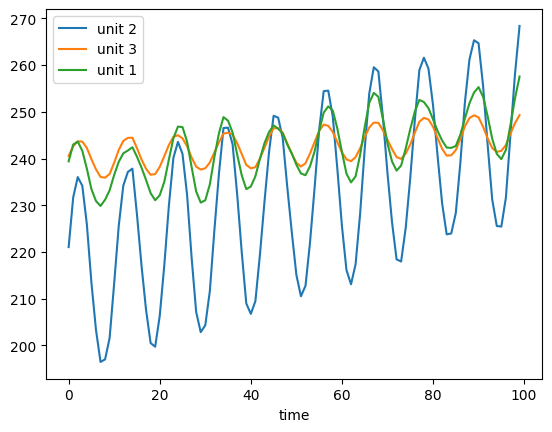

In [19]:
T = 100
data, periods = generate_syn_data(T)
tensor, full_df = data.generate([0,T-1])
ss_tensor, df = data.auto_subsample(periods, tensor, full_df)
obs = np.full(tensor.shape, np.nan)
obs[data.mask == 1] = tensor[data.mask ==1]


plt.plot(tensor[0,:,:,0])
plt.xlabel('time')
plt.legend({"unit 1", "unit 2", "unit 3"})


# Average Treatment Effect Estimation

## Estimand

Estimate the ATE for each intervention $i$ in our population of interest.  The ATE for intervention $i$ is defined as follows:
$$ATE(i) = \frac{1}{NT}(\sum_t \sum_n  Y^i_{n,t} - \sum_t \sum_n Y^0_{n,t})$$
Where 0 denotes control. 


## Baseline

In these set of baselines, we will also assume access to a unit specific covariates vector $X_i$. 

####  Inverse Probability Weighting (IPW).
In this baseline, we estimate the $ATE(i)$ for each intervention using the IPW estimator. We use logistic regression to estimate the propensity.


In [20]:

def ipw_estimator(df, treatment, confounders, outcome, obs):
    # fit weights
    N, T, I,_ = obs.shape
    learner = RandomForestClassifier()
    ipw = IPW(learner)
    X = pd.get_dummies(df[confounders])
    a = df[treatment]
    y = df[outcome]
    
    if len(a.unique()) == 1:
        outcomes =  pd.Series(data = np.ones(I) * y.mean(), index = np.arange(I))
    else:
        ipw.fit(X, a)
        # Estimate average outcome
        outcomes = ipw.estimate_population_outcome(X, a, y)
    return outcomes


## Experiments and Results

In [21]:
# What-if baselines
tensor_est, mask = what_if(df, obs[...,0], method = "SNN")
tensor_est_SNNB, mask = what_if(df, obs[...,0], method = "SNNB")
tensor_est_ALS, _ = what_if(df, obs[...,0], method = "ALS")
## get ATE
ATE_SNN = [[np.nanmean(tensor_est[:,:,i] - tensor_est[:,:,0]) for i in range(3)]]
ATE_SNNB = [[np.nanmean(tensor_est_SNNB[:,:,i] - tensor_est_SNNB[:,:,0]) for i in range(3)]]
ATE_ALS = [[np.nanmean(tensor_est_ALS[:,:,i] - tensor_est_ALS[:,:,0]) for i in range(3)]]

# IPW
outcomes = ipw_estimator(
      df, treatment = "intervention", 
      confounders = ["age", "location"],
      outcome = "sales", 
      obs = obs,
    )
## get ATE
ATE_ipw = [[outcomes[i] - outcomes[0] for i in range(3)]]
# get true ATE
ATE_true = [[(tensor[:,:,i] - tensor[:,:,0]).mean() for i in range(3)]]



/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:357: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  metric_matrix_df = df.pivot(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:371: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  current_true_intervention_assignment_matrix = df.pivot(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:357: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  metric_matrix_df = df.pivot(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:371: FutureWarning: In a fu

Generated 6 clusters


/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:357: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  metric_matrix_df = df.pivot(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/benchmarking/../algorithms/fill_tensor_base.py:371: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  current_true_intervention_assignment_matrix = df.pivot(


In [23]:
res_df = pd.DataFrame( data = np.concatenate([ATE_SNN, ATE_SNNB, ATE_ALS, ATE_ipw, ATE_true])[:,1:],
                  columns = ["ATE(1)", "ATE(2)"], index = ["SNN", "SNNB", "ALS", "IPW", "true"])
res_df

,ATE(1),ATE(2)
SNN,11.055600,21.015346
SNNB,11.289020,21.469248
ALS,-35.135932,-15.211981
IPW,11.579586,18.707597
true,9.627191,21.081994


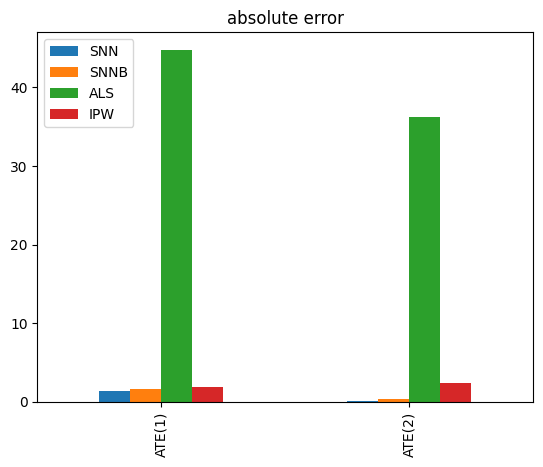

,ATE(1),ATE(2)
SNN,1.428409,0.066648
SNNB,1.661829,0.387254
ALS,44.763123,36.293975
IPW,1.952394,2.374397


In [24]:
# error 
error = np.abs(res_df.iloc[:-1, :] - res_df.iloc[-1, :])
error.T.plot.bar(title = "absolute error")
plt.show()
error

# Time-dependent (dynamic) Average Treatment Effect Estimation

## Estimand

Estimate the ATE for each intervention $i$ and time $t$ in our population of interest.  The ATE for intervention $i$ and time $t$ is defined as follows:
$$ATE(i, t) = \frac{1}{N}( \sum_n  Y^i_{n,t} - \sum_n Y^0_{n,t})$$
Where 0 denotes control. 


## Baseline

In these set of baselines, we will also assume access to a unit specific covariates vector $X_i$. 

####  Inverse Probability Weighting (IPW).
In this baseline, we estimate the $ATE(i,t)$ for each intervention and time step using the IPW estimator. We use logistic regression to estimate the propensity.


In [25]:
def ipw_estimator_t(df, time, treatment, confounders, outcome, obs):
    N, T, I, _ = obs.shape
    
    outcomes = np.zeros([T, I])
    timestamps = np.sort(pd.unique(df.time))
    for t in range(T):
        df_t = df.loc[df[time] == timestamps[t]]
        assert df_t.shape[0] > 0
        outcomes[t,:] = ipw_estimator(df_t, treatment, confounders, outcome, obs[:,t:t+1, :, :])
    return outcomes
    

## Experiments and Results

In [26]:
## get ATE from what-if baselines
ATE_SNN_t = np.array([[np.nanmean(tensor_est[:,t,i] - tensor_est[:,t,0]) for i in range(3)] for t in range(T)])
ATE_SNNB_t = np.array([[np.nanmean(tensor_est_SNNB[:,t,i] - tensor_est_SNNB[:,t,0]) for i in range(3)] for t in range(T) ])
ATE_ALS_t = np.array([[np.nanmean(tensor_est_ALS[:,t,i] - tensor_est_ALS[:,t,0]) for i in range(3)] for t in range(T)])

# IPW
outcomes = ipw_estimator_t(
      df, treatment = "intervention", 
      confounders = ["age", "location"],
      outcome = "sales",
      time = "time",
      obs = obs,
    )
## get ATE
ATE_ipw = np.array([[outcomes[t, i] - outcomes[t,0] for i in range(3)] for t in range(T)])
# get true ATE
ATE_true = np.array([[(tensor[:,t,i] - tensor[:,t,0]).mean() for i in range(3)] for t in range(T)])



/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_2726/2330580634.py:2: RuntimeWarning: Mean of empty slice
  ATE_SNN_t = np.array([[np.nanmean(tensor_est[:,t,i] - tensor_est[:,t,0]) for i in range(3)] for t in range(T)])
/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_2726/2330580634.py:3: RuntimeWarning: Mean of empty slice
  ATE_SNNB_t = np.array([[np.nanmean(tensor_est_SNNB[:,t,i] - tensor_est_SNNB[:,t,0]) for i in range(3)] for t in range(T) ])


In [27]:
np.array(ATE_ALS_t).shape

(100, 3)

In [28]:
results = pd.DataFrame(columns = ["method", "intervention"] + list(range(T)))
for i in range(1,3):
    results.loc[results.shape[0]] = ["SNN", i] + list(ATE_SNN_t[:,i])
    results.loc[results.shape[0]] =["SNNB", i] + list(ATE_SNNB_t[:,i])
#     results.loc[results.shape[0]] = ["ALS", i] + list(ATE_ALS_t[:,i])
    results.loc[results.shape[0]] =["IPW", i] + list(ATE_ipw[:,i])
    results.loc[results.shape[0]] = ["True", i] + list(ATE_true[:,i])
results

,method,intervention,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,SNN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.510496,7.977342,9.948946,11.731038,12.562292,12.539910,11.571539,9.507232,7.530120,5.971676
1,SNNB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.048261,9.732709,10.686193,11.573295,12.012328,12.030837,11.564873,10.542460,9.547360,8.759522
2,IPW,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.133018,10.573760,10.754802,10.534306,11.399324,11.079983,11.138145,12.335756,13.445702,11.481093
3,True,1,10.656722,9.630503,9.153233,9.239737,9.965079,11.158391,12.192983,12.943422,...,6.525209,7.479047,8.705258,9.771489,10.226754,10.163943,9.557763,8.314061,7.149348,6.237035
4,SNN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.488535,20.667088,20.899695,21.104374,21.194281,21.185174,21.070408,20.832176,20.607506,20.431174
5,SNNB,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.583348,21.539462,21.486588,21.443405,21.427867,21.433818,21.460216,21.511181,21.557098,21.592661
6,IPW,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.352061,14.067405,16.890598,18.499066,19.882169,19.423437,18.881682,18.225290,16.112831,13.717384
7,True,2,21.276033,21.081267,20.992965,21.013029,21.153531,21.380406,21.574397,21.713388,...,20.488827,20.667137,20.899572,21.104210,21.194215,21.185244,21.070575,20.832413,20.607737,20.431384


<AxesSubplot: >

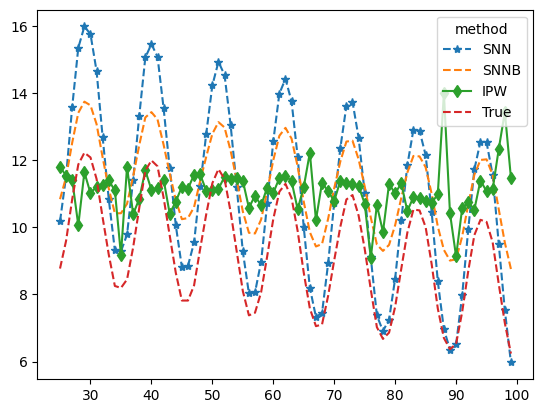

In [29]:
ate_1 = results.loc[results.intervention == 1].T.iloc[27:,:]
ate_2 = results.loc[results.intervention == 2].T.iloc[27:,:]
ate_1.columns = results.loc[results.intervention == 1, "method"]
ate_2.columns = results.loc[results.intervention == 2, "method"]
styles2 = ["--*",'--','-d','--']
ate_1.plot(style = styles2)


<AxesSubplot: >

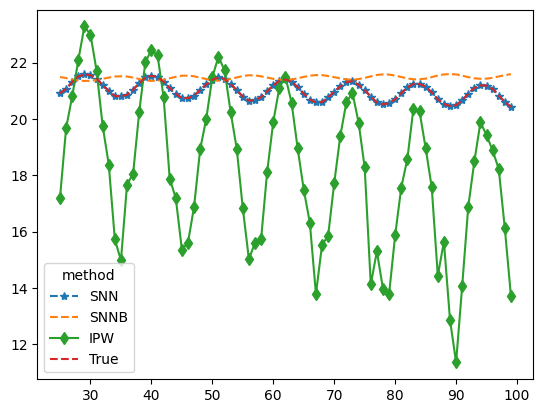

In [30]:
styles2 = ["--*",'--','-d','--']
ate_2.plot(style = styles2)


# Conditional Average Treatment Effect Estimation

## Estimand

Estimate the CATE for each intervention $i$ and each covariate value $x$ in our population of interest.  The CATE for intervention $i$ is defined as follows:
$$CATE(i,x) = \frac{1}{N(x)T}(\sum_t \sum_{n: X_n = x}  Y^i_{n,t} - \sum_t \sum_{n: X_n = x} Y^0_{n,t})$$
Where 0 denotes control, and $N(x)$ denotes the number of units with covaraites value of x. 


## Baseline


####   DoublyRobust (DR).
This baseline learns CATO and combines both:
1. A weight model (learned by logistic regression) to estimate propensity;
2. An outcome model (linear regression or randomForestRegressor) that predicts the outcome as a function of treatment, covariates.
The estimator uses importance sampling using the estimated weights when learning the outcome model.


In [31]:
def dr_estimator(df, treatment, confounders, outcome, obs, unit, unique_x,  outcome_model = RandomForestRegressor()  ):
    # fit weights
    N, T, I,_ = obs.shape
    learner = RandomForestClassifier()
    ipw = IPW(learner)
    std = Standardization(outcome_model)
    dr = WeightedStandardization(std, ipw)
    X = pd.get_dummies(df[confounders])
    a = df[treatment].rename("treatment")
    y = df[outcome].rename("outcome")
    N_x = len(unique_x)
    if len(a.unique()) == 1:
        ind_outcomes =  pd.DataFrame(data = np.ones([N_x,I]) * y.mean(), index = np.arange(N))
    else:
        dr.fit(X, a, y)
        # Estimate average outcome
        ind_outcomes = dr.estimate_individual_outcome(unique_x, a)
    return ind_outcomes
    

## Experiments and Results

In [32]:
# get all unique features/covariates 
confounders = ["age", "location"]
X = pd.get_dummies(df[confounders])

unique_x = X.drop_duplicates()

# estimate CATE for these cov using DR
CATE_dr = dr_estimator(
            df, treatment = "intervention", 
            confounders = ["age", "location"],
            outcome = "sales", 
            obs = obs,
            unit = "unit_id",
            unique_x = unique_x
            )

# estimate CATE for these cov using DR with linear outcome model
CATE_dr_linear = dr_estimator(
            df, treatment = "intervention", 
            confounders = ["age", "location"],
            outcome = "sales", 
            obs = obs,
            unit = "unit_id",
            unique_x = unique_x,
            outcome_model = LinearRegression()
            )

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/whatIf-Env/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was

In [33]:

## get CATE from what-ifs and true
CATE_SNN = np.zeros([len(unique_x), 2])
CATE_SNNB = np.zeros([len(unique_x), 2])
CATE_ALS = np.zeros([len(unique_x), 2])
CATE_true = np.zeros([len(unique_x), 2])
for i, x in enumerate(unique_x.iterrows()):
    x = x[1].values
    units_x = pd.concat([X, df.loc[:,"unit_id"]], axis = 1).groupby("unit_id").min() 
    units_ind = units_x.loc[(units_x != x).sum(1) == 0].index
    CATE_SNN[i,:] = [np.nanmean(tensor_est[units_ind,:,i] - tensor_est[units_ind,:,0]) for i in range(1,3)]
    CATE_SNNB[i,:] = [np.nanmean(tensor_est_SNNB[units_ind,:,i] - tensor_est_SNNB[units_ind,:,0]) for i in range(1,3)]
    CATE_ALS[i,:] = [np.nanmean(tensor_est_ALS[units_ind,:,i] - tensor_est_ALS[units_ind,:,0]) for i in range(1,3)]
    # get true ATE
    CATE_true[i,:] = [(tensor[units_ind,:,i] - tensor[units_ind,:,0]).mean() for i in range(1,3)]


In [34]:
results = pd.DataFrame(columns = ["method", "intervention"] + list(range(len(unique_x))))
for i in range(2):
    results.loc[results.shape[0]] = ["SNN", i+1] + list(CATE_SNN[:,i])
    results.loc[results.shape[0]] =["SNNB", i+1] + list(CATE_SNNB[:,i])
    results.loc[results.shape[0]] = ["ALS", i+1] + list(CATE_ALS[:,i])
    results.loc[results.shape[0]] =["DR", i+1] + list(CATE_dr.values[:,i])
    results.loc[results.shape[0]] =["DR_linear", i+1] + list(CATE_dr_linear.values[:,i])
    results.loc[results.shape[0]] = ["True", i+1] + list(CATE_true[:,i])
results

,method,intervention,0,1,2,3,4,5,6,7
0,SNN,1,20.167011,22.211129,-1.807946,18.962870,22.660564,-10.742296,29.903760,-12.686421
1,SNNB,1,23.628332,14.352109,11.817591,5.999098,15.572883,-0.205289,7.373601,-1.803166
2,ALS,1,-65.805921,-39.805625,0.798299,-23.077794,-17.436973,-84.389804,33.044165,-31.706332
3,DR,1,206.278151,208.100874,223.541973,201.825813,190.737690,238.229931,180.983019,230.525450
4,DR_linear,1,214.500000,205.750000,227.250000,195.250000,196.000000,228.500000,197.250000,226.250000
5,True,1,21.857501,25.529881,2.183340,21.110409,19.477948,-25.369903,27.197671,-21.861574
6,SNN,2,25.716022,30.461221,6.092300,32.757987,35.700942,-1.161458,45.573538,2.327322
7,SNNB,2,24.224563,16.362129,26.975820,13.032397,19.814848,26.564148,14.277157,26.934244
8,ALS,2,13.146058,18.589647,-48.869385,-57.837859,-60.626391,-0.360480,-50.523195,60.725872
9,DR,2,241.479455,218.041578,235.654818,207.646519,207.544844,236.335230,194.219845,219.537201


In [35]:
CATE_dr

treatment,0,1,2
0,206.278151,241.479455,226.299473
100,208.100874,218.041578,222.170549
200,223.541973,235.654818,251.159556
400,201.825813,207.646519,213.591102
500,190.737690,207.544844,216.508719
800,238.229931,236.335230,247.523406
1600,180.983019,194.219845,214.174061
2100,230.525450,219.537201,244.795645


<AxesSubplot: xlabel='x'>

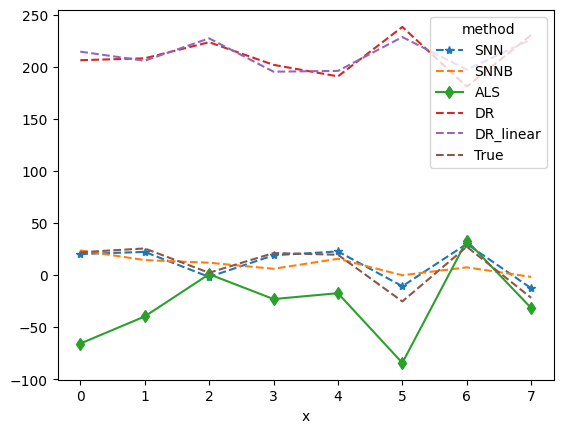

In [36]:
cate_1 = results.loc[results.intervention == 1].T.iloc[2:,:]
cate_2 = results.loc[results.intervention == 2].T.iloc[2:,:]
cate_1.columns = results.loc[results.intervention == 1, "method"]
cate_2.columns = results.loc[results.intervention == 2, "method"]
styles2 = ["--*",'--','-d','--', '--', '--']
cate_1.plot(style = styles2, xlabel = "x")



<AxesSubplot: xlabel='x'>

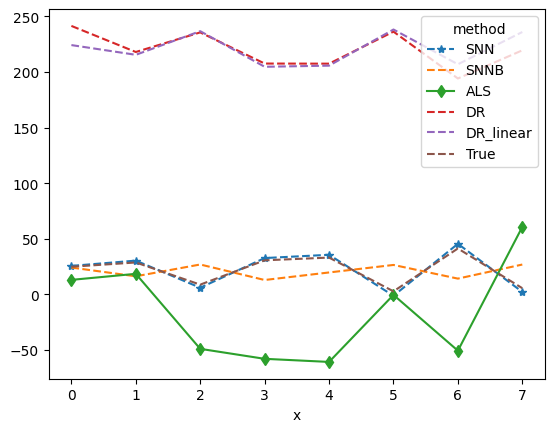

In [37]:
cate_2.plot(style = styles2, xlabel = "x")


# Time-dependent (dynamic) Conditional Average Treatment Effect Estimation

## Setup

## Baselines



## Results

**Observation**: T measurements of N units for a specific metric $Y$ under one of $I$ interventions. We assume access to one observation per unit and time. 

**Goal**: Predict the metric of interest $Y^i_{n,t}$ for each unit $n\in[N]$, in each timestep $t\in[T]$, under any intervention $i\in [I]$. 